Entrenando fold 1...
Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - loss: 3551.7664 - salida_clase_accuracy: 0.3942 - salidas_continuas_mae: 44.4309 - val_loss: 7225.5732 - val_salida_clase_accuracy: 0.3491 - val_salidas_continuas_mae: 74.7911 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 854.3887 - salida_clase_accuracy: 0.6093 - salidas_continuas_mae: 22.6779 - val_loss: 5393.2891 - val_salida_clase_accuracy: 0.2633 - val_salidas_continuas_mae: 63.8718 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 634.6960 - salida_clase_accuracy: 0.7117 - salidas_continuas_mae: 18.7566 - val_loss: 3114.4524 - val_salida_clase_accuracy: 0.3269 - val_salidas_continuas_mae: 47.4143 - learning_rate: 0.0010
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 539.0588 - salida_clase_accuracy: 0.7769 - salidas_continuas_mae: 17.1103 - val_loss: 1642.0148 - val_salida_clase_accuracy: 0.4749 - val_salidas_continua

<Figure size 1200x800 with 0 Axes>

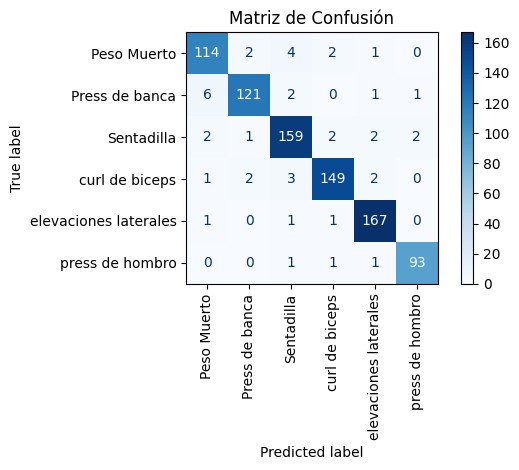

Entrenando fold 2...
Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 3379.9080 - salida_clase_accuracy: 0.4078 - salidas_continuas_mae: 43.2030 - val_loss: 7994.3179 - val_salida_clase_accuracy: 0.3170 - val_salidas_continuas_mae: 79.3202 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 756.9500 - salida_clase_accuracy: 0.6665 - salidas_continuas_mae: 21.1554 - val_loss: 5822.7510 - val_salida_clase_accuracy: 0.2089 - val_salidas_continuas_mae: 67.3215 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 589.2977 - salida_clase_accuracy: 0.7116 - salidas_continuas_mae: 18.0701 - val_loss: 3251.3274 - val_salida_clase_accuracy: 0.2237 - val_salidas_continuas_mae: 49.1303 - learning_rate: 0.0010
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 539.3851 - salida_clase_accuracy: 0.7454 - salidas_continuas_mae: 17.1430 - val_loss: 2004.7535 - val_salida_clase_accuracy: 0.5289 - val_salidas_conti

<Figure size 1200x800 with 0 Axes>

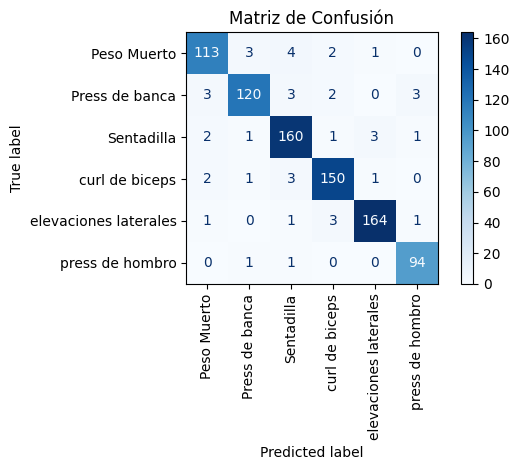

Entrenando fold 3...
Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - loss: 3456.6758 - salida_clase_accuracy: 0.4008 - salidas_continuas_mae: 43.9099 - val_loss: 6475.8237 - val_salida_clase_accuracy: 0.3748 - val_salidas_continuas_mae: 70.3075 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 916.1514 - salida_clase_accuracy: 0.6066 - salidas_continuas_mae: 23.7278 - val_loss: 5135.0942 - val_salida_clase_accuracy: 0.3541 - val_salidas_continuas_mae: 62.1799 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 657.6152 - salida_clase_accuracy: 0.6984 - salidas_continuas_mae: 19.4081 - val_loss: 2762.1008 - val_salida_clase_accuracy: 0.4800 - val_salidas_continuas_mae: 44.6786 - learning_rate: 0.0010
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 568.4285 - salida_clase_accuracy: 0.7812 - salidas_continuas_mae: 17.6389 - val_loss: 1724.1222 - val_salida_clase_accuracy: 0.4119 - val_salidas_conti

<Figure size 1200x800 with 0 Axes>

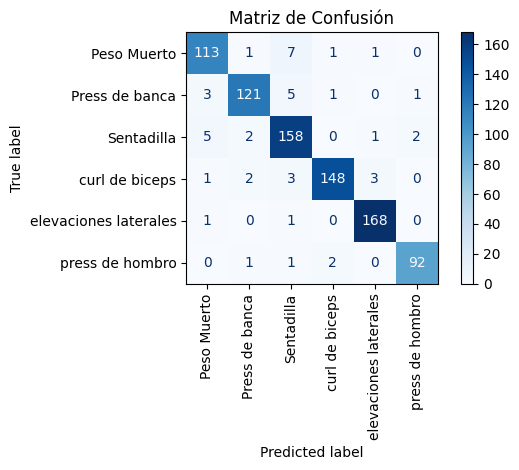

Entrenando fold 4...
Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - loss: 3480.4944 - salida_clase_accuracy: 0.3877 - salidas_continuas_mae: 44.2561 - val_loss: 5486.8989 - val_salida_clase_accuracy: 0.3585 - val_salidas_continuas_mae: 64.0568 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 938.6713 - salida_clase_accuracy: 0.5749 - salidas_continuas_mae: 24.0489 - val_loss: 3972.7256 - val_salida_clase_accuracy: 0.2652 - val_salidas_continuas_mae: 53.9640 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 681.7804 - salida_clase_accuracy: 0.6924 - salidas_continuas_mae: 19.9232 - val_loss: 3063.7771 - val_salida_clase_accuracy: 0.4222 - val_salidas_continuas_mae: 47.1814 - learning_rate: 0.0010
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 573.0410 - salida_clase_accuracy: 0.7508 - salidas_continuas_mae: 17.8528 - val_loss: 2002.8376 - val_salida_clase_accuracy: 0.4830 - val_salidas_conti

<Figure size 1200x800 with 0 Axes>

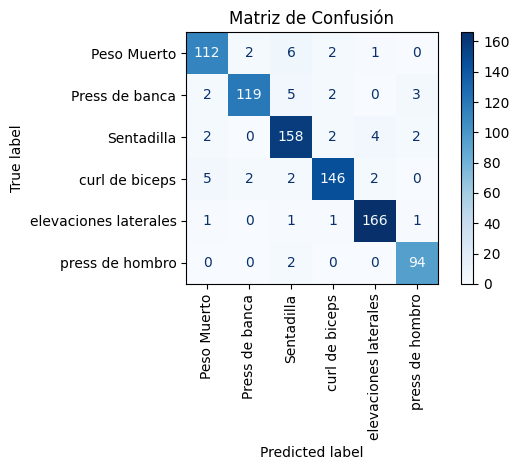

Entrenando fold 5...
Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - loss: 3416.0979 - salida_clase_accuracy: 0.4328 - salidas_continuas_mae: 43.6921 - val_loss: 7729.5454 - val_salida_clase_accuracy: 0.3541 - val_salidas_continuas_mae: 77.7118 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 822.4434 - salida_clase_accuracy: 0.6372 - salidas_continuas_mae: 22.1824 - val_loss: 6586.1987 - val_salida_clase_accuracy: 0.1867 - val_salidas_continuas_mae: 71.3575 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 623.4379 - salida_clase_accuracy: 0.7162 - salidas_continuas_mae: 18.6808 - val_loss: 4095.3508 - val_salida_clase_accuracy: 0.3511 - val_salidas_continuas_mae: 55.4111 - learning_rate: 0.0010
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 535.6248 - salida_clase_accuracy: 0.7861 - salidas_continuas_mae: 17.1626 - val_loss: 2432.8457 - val_salida_clase_accuracy: 0.4296 - val_salidas_conti

<Figure size 1200x800 with 0 Axes>

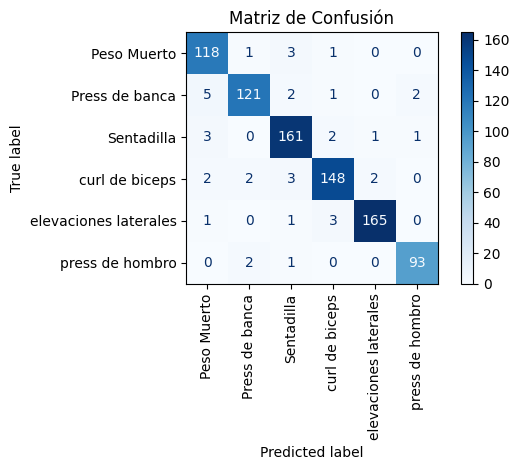

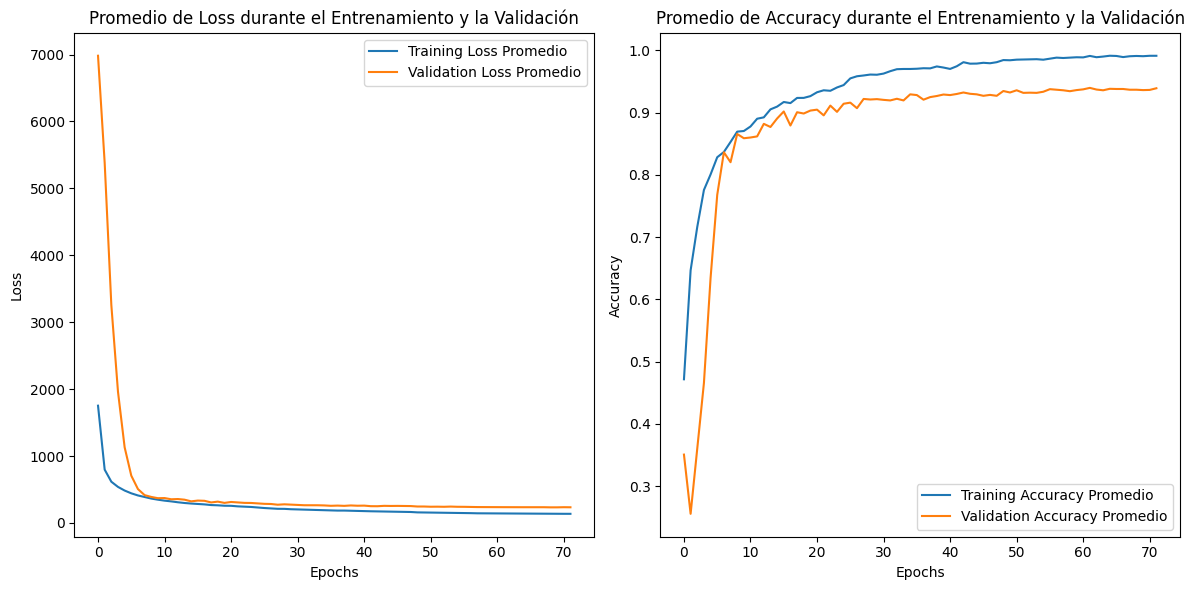


Métricas promedio de todos los folds:
Loss: 199.5251037597656
MAE: 9.028243647601933
MSE: 197.64300872533278
RMSE: 14.0574967838063
R^2: 0.9131040306223539
Accuracy: 0.9479289889335633
Precisión: 0.9482465355598227
Recall: 0.9479289940828404
F1-Score: 0.9479183903369414


In [3]:
import joblib
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, Attention, Concatenate

# Cargar datos
ruta_actual = os.getcwd()
carpeta_mediapipe = os.path.dirname(ruta_actual)
ruta_csv = os.path.join(carpeta_mediapipe, 'Datos_Pose', 'pose_data_images.csv')
ruta_npy = os.path.join(ruta_actual, 'datos', 'classes.npy')
ruta_scaler = os.path.join(ruta_actual, 'datos', 'scaler_X.pkl')
ruta_modelo = os.path.join(ruta_actual, 'model', 'exercise_model.h5')

data = pd.read_csv(ruta_csv)

# Preparar datos
num_keypoints = 33 * 3
X = data.iloc[:, :num_keypoints].values
y_continuas = data.iloc[:, num_keypoints:(data.shape[1] - 1)].values
y_clase = data.iloc[:, -1].values

encoder = LabelEncoder()
y_clase_encoded = encoder.fit_transform(y_clase)
num_clases = len(encoder.classes_)

X_train, X_test, y_continuas_train, y_continuas_test, y_clase_train, y_clase_test = train_test_split(
    X, y_continuas, y_clase_encoded, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Función para crear el modelo con ajustes adicionales
def create_model(learning_rate=0.001):
    input_layer = Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))

    # Capas Bidireccionales LSTM
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    # Aplicar mecanismo de atención
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    
    x = Flatten()(x)
    
    salidas_continuas = Dense(6, activation='linear', name='salidas_continuas')(x)
    salida_clase = Dense(num_clases, activation='softmax', name='salida_clase')(x)
    
    model = Model(inputs=input_layer, outputs=[salidas_continuas, salida_clase])
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss={'salidas_continuas': 'mean_squared_error', 'salida_clase': 'sparse_categorical_crossentropy'},
                  metrics={'salidas_continuas': 'mae', 'salida_clase': 'accuracy'})
    
    return model
# Listas para almacenar métricas
all_loss = []
all_mae = []
all_mse = []
all_rmse = []
all_r2 = []
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []

# Matrices para almacenar la historia del entrenamiento
n_epochs = 150  # Número de épocas
all_train_loss = np.full((5, n_epochs), np.nan)  
all_val_loss = np.full((5, n_epochs), np.nan)
all_train_accuracy = np.full((5, n_epochs), np.nan)
all_val_accuracy = np.full((5, n_epochs), np.nan)

# Ejecutar el entrenamiento con el modelo modificado
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fold_index = 0
for train_index, val_index in kfold.split(X_train_rnn):
    fold_index += 1
    print(f"Entrenando fold {fold_index}...")

    X_train_fold, X_val_fold = X_train_rnn[train_index], X_train_rnn[val_index]
    y_continuas_train_fold, y_continuas_val_fold = y_continuas_train[train_index], y_continuas_train[val_index]
    y_clase_train_fold, y_clase_val_fold = y_clase_train[train_index], y_clase_train[val_index]

    model = create_model(learning_rate=0.001)  # Ajuste de tasa de aprendizaje
    tensorboard_callback = TensorBoard(log_dir=os.path.join(ruta_actual, 'logs', f'fold_{fold_index}'), histogram_freq=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    history = model.fit(X_train_fold, {'salidas_continuas': y_continuas_train_fold, 'salida_clase': y_clase_train_fold},
                        validation_data=(X_val_fold, {'salidas_continuas': y_continuas_val_fold, 'salida_clase': y_clase_val_fold}),
                        epochs=n_epochs, batch_size=32, callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr_callback])

    # Almacenar la historia del entrenamiento como matrices NumPy
    epochs_completed = len(history.history['loss'])
    all_train_loss[fold_index - 1, :epochs_completed] = history.history['loss']
    all_val_loss[fold_index - 1, :epochs_completed] = history.history['val_loss']
    all_train_accuracy[fold_index - 1, :epochs_completed] = history.history['salida_clase_accuracy']
    all_val_accuracy[fold_index - 1, :epochs_completed] = history.history['val_salida_clase_accuracy']

    # Evaluar el modelo en el conjunto de prueba
    scores = model.evaluate(X_test_rnn, {'salidas_continuas': y_continuas_test, 'salida_clase': y_clase_test})
    print(f"Fold {fold_index}: Loss={scores[0]}, MAE={scores[2]}, Accuracy={scores[1]}")

    # Calcular métricas adicionales para las salidas continuas
    y_pred_continuas = model.predict(X_test_rnn)[0]
    mae = mean_absolute_error(y_continuas_test, y_pred_continuas)
    mse = mean_squared_error(y_continuas_test, y_pred_continuas)
    rmse = np.sqrt(mse)
    r2 = 1 - mse / np.var(y_continuas_test)

    all_loss.append(scores[0])
    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)
    all_r2.append(r2)
    all_accuracy.append(scores[1])

    # Calcular métricas de clasificación
    y_pred_clase = np.argmax(model.predict(X_test_rnn)[1], axis=1)
    precision = precision_score(y_clase_test, y_pred_clase, average='weighted')
    recall = recall_score(y_clase_test, y_pred_clase, average='weighted')
    f1 = f1_score(y_clase_test, y_pred_clase, average='weighted')

    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

    # Imprimir matriz de confusión
    cm = confusion_matrix(y_clase_test, y_pred_clase, labels=np.unique(y_clase_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    plt.figure(figsize=(12, 8))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Matriz de Confusión')
    plt.tight_layout()
    plt.show()

# Promediar las historias del entrenamiento
mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)
mean_train_accuracy = np.mean(all_train_accuracy, axis=0)
mean_val_accuracy = np.mean(all_val_accuracy, axis=0)

# Graficar los promedios
plt.figure(figsize=(12, 6))

# Promedio de Loss
plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, label='Training Loss Promedio')
plt.plot(mean_val_loss, label='Validation Loss Promedio')
plt.title('Promedio de Loss durante el Entrenamiento y la Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Promedio de Accuracy
plt.subplot(1, 2, 2)
plt.plot(mean_train_accuracy, label='Training Accuracy Promedio')
plt.plot(mean_val_accuracy, label='Validation Accuracy Promedio')
plt.title('Promedio de Accuracy durante el Entrenamiento y la Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Imprimir métricas promedio de todos los folds
print("\nMétricas promedio de todos los folds:")
print(f"Loss: {np.mean(all_loss)}")
print(f"MAE: {np.mean(all_mae)}")
print(f"MSE: {np.mean(all_mse)}")
print(f"RMSE: {np.mean(all_rmse)}")
print(f"R^2: {np.mean(all_r2)}")
print(f"Accuracy: {np.mean(all_accuracy)}")
print(f"Precisión: {np.mean(all_precision)}")
print(f"Recall: {np.mean(all_recall)}")
print(f"F1-Score: {np.mean(all_f1)}")

# Guardar el modelo
model.save(ruta_modelo)
joblib.dump(scaler_X, ruta_scaler)
np.save(ruta_npy, encoder.classes_)
